In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['savefig.dpi'] = 200

## Data Index

All data collected on Raspberry Pi 4B 4GB. Software version are `Ubuntu 20.04.4 LTS` with `5.4.140-rt64` (RT) and `5.4.0-1052-raspi` (Non RT).

For non RT: 

| Filename | RT? | Notes |
|----------|-----|-------|
| `idle-cylictest.log` | Yes | Test with system idling |
| `hdd-cyclictest.log` | Yes | Test with HDD stress via `stress-ng --hdd 2` |
| `hackbench-cyclictest.log` | Yes | Test with hackbench via `while true; do hackbench; done` |
| `memory-cyclictest.log` | Yes | Test with memory stress via `stress-ng --brk 0 --stack 0 --bigheap 0` |
| `ping-cyclictest.log` | Yes | Test with ping flooding from another machine over ethernet by running `ping -f <raspberrypihost>` from the other machine |
| `stress-cyclictest.log` | Yes | Test with CPU stress via `stress-ng -c 4` |
| `cpu-hdd-hackbench-cyclictest.log` | Yes | Test with CPU + HDD + hackbench all at the same time |
| `stress-memory-cyclictest.log` | Yes | Test with CPU + memory at the same time via `stress-ng --brk 0 --stack 0 --bigheap 0 --cpu 4` |
| `non-rt-cyclictest.log` | No | Test with system idling without PREEMPT_RT patch |
| `non-rt-stress-cyclictest.log` | No | Test with `stress-ng -c 4` without PREEMPT_RT patch |
| `rt-stress-no-multipathd-cyclictest.log` | Yes | Tested with `stress-ng -c 4` with RT, but with multipathd disabled (See this issue) |

In [2]:
import re

def to_numbers(line):
  for i, v in enumerate(line):
    v = v.lstrip("0")
    if v == "":
      v = 0
    else:
      v = int(v)

    line[i] = v
  
  return line

def load_histogram(filename, **kwargs):
  ncols = -1
  histogram_size = 0
  
  with open(filename) as f:
    for line_num, line in enumerate(f):
      line = line.strip()
      if line.startswith("#"):
        continue
      
      if line == "":
        continue
        
      line = re.split(r"\s+", line)
      if ncols == -1:
        ncols = len(line)
      elif ncols != len(line):
        print(f"data is corrupted on line {line_num} as it has {len(line)} instead of the expected {ncols}: {line}")
        return
      
      histogram_size += 1
    
  data = np.empty((histogram_size, ncols), dtype=np.int64)

  idx = 0
  max_latency = -1

  with open(filename) as f:
    for line_num, line in enumerate(f):
      line = line.strip()
      
      if line.startswith("# Max Latencies"):
        line = line.split(":")[1]
        line = re.split(r"\s+", line.strip())
        to_numbers(line)
        max_latency = max(line)
        continue
      
      if line.startswith("#"):
        continue

      if line == "":
        continue
        
      line = re.split(r"\s+", line)
      to_numbers(line)
      
      if sum(line[1:-1]) != line[-1]: # Because I used histofall for logging
        print(f"line {line_num}: last column doesn't match with the sum of the other columns")
        return
      
      data[idx, :] = line
      idx += 1
  
  kwargs["max"] = max_latency
  return data, kwargs

def plot_data(datas, ax=None, xlim=(0, 500)):
  if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
  
  lines = []
  for data, aux_data in datas:
    l, = ax.plot(data[:, 0], data[:, 1], aux_data["style"], label=f"{aux_data['label']} (Max = {aux_data['max']}μs)")
    lines.append(l)
  
  ax.set_yscale("log")
  ax.set_xlim(xlim)
  ax.set_xlabel("Latency (μs)")
  ax.set_ylabel("Count")
  ax.grid()
  ax.legend(handles=lines)

## RT Data Analysis

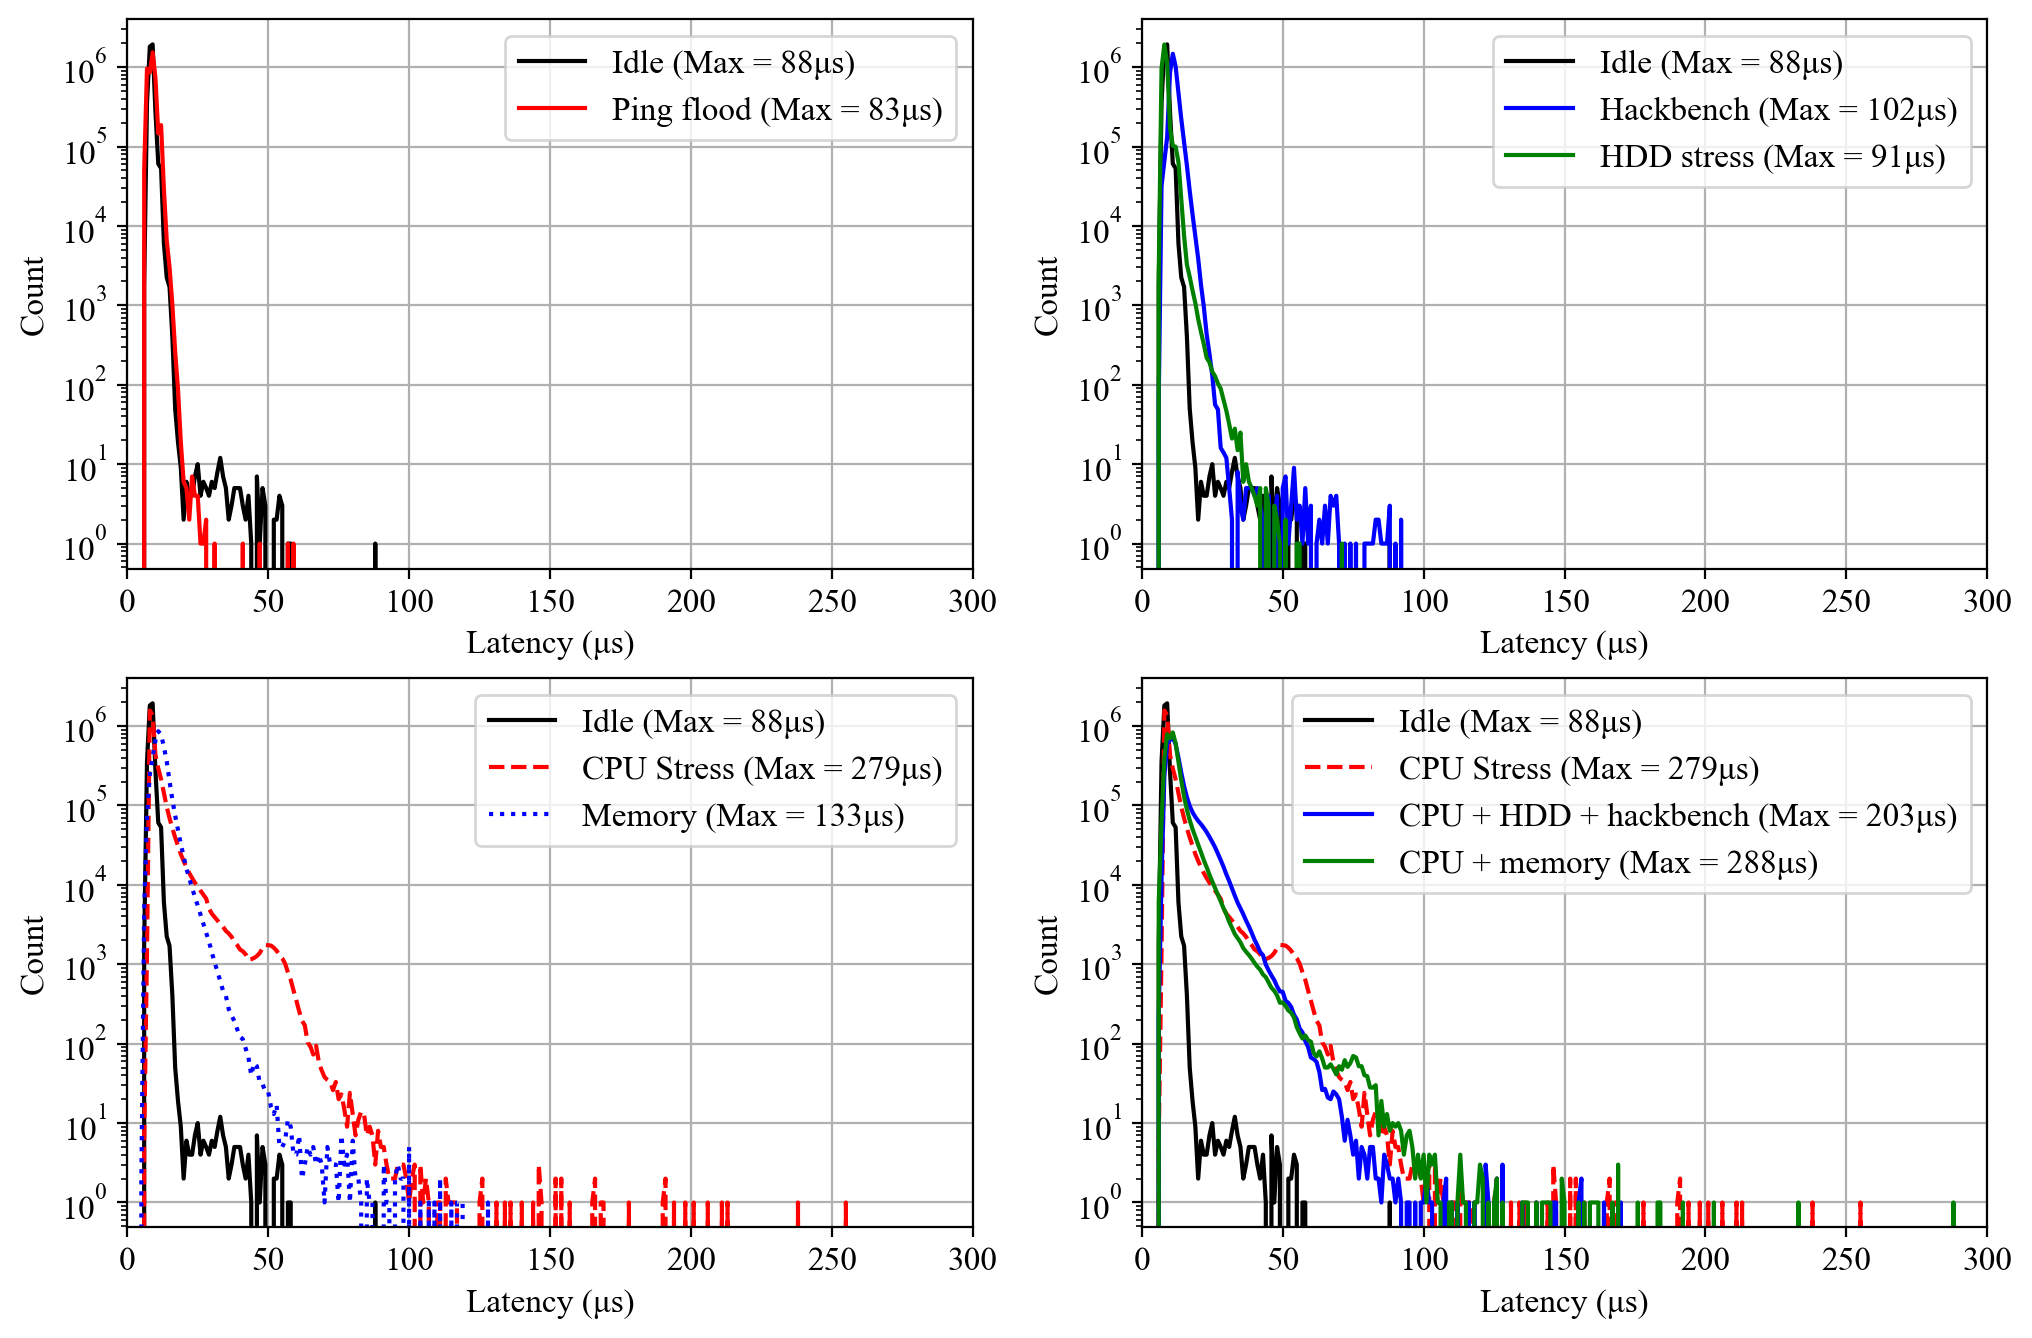

In [3]:
idle = load_histogram("data/idle-cyclictest.log", style="k-", label="Idle")
ping_flood = load_histogram("data/ping-cyclictest.log", style="r-", label="Ping flood")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
plot_data((idle, ping_flood), ax=ax, xlim=(0, 300))

hackbench = load_histogram("data/hackbench-cyclictest.log", style="b-", label="Hackbench")
hdd = load_histogram("data/hdd-cyclictest.log", style="g-", label="HDD stress")

ax = fig.add_subplot(2, 2, 2)
plot_data((idle, hackbench, hdd), ax=ax, xlim=(0, 300))


stress = load_histogram("data/stress-cyclictest.log", style="r--", label="CPU Stress")
stress_combined = load_histogram("data/cpu-hdd-hackbench-cyclictest.log", style="b-", label="CPU + HDD + hackbench")
stress_memory = load_histogram("data/stress-memory-cyclictest.log", style="g-", label="CPU + memory")
memory = load_histogram("data/memory-cyclictest.log", style="b:", label="Memory")

ax = fig.add_subplot(2, 2, 3)
plot_data((idle, stress, memory), ax=ax, xlim=(0, 300))

ax = fig.add_subplot(2, 2, 4)
plot_data((idle, stress, stress_combined, stress_memory), ax=ax, xlim=(0, 300))

## Conclusions

- Ping flooding from another host probably doesn't matter as it makes no difference in the latency histogram (top left plot)
- Hackbench and HDD are pretty similar to each other (top right plot)
- Memory allocation stress makes a bit of a difference despite mlockall (bottom left), but makes some sense because the CPU usage is quite high with memory stress
- Hackbench + HDD + CPU is pretty similar to just CPU stressing, implying hat hackbench + HDD stressing is not really a factor in latency (bottom right)
- Memory + CPU stress is also very similar to pure CPU stressing (bottom right). This with the above means CPU stress is the only dominant factor for RT for all these testing.

## RT vs Non RT comparison

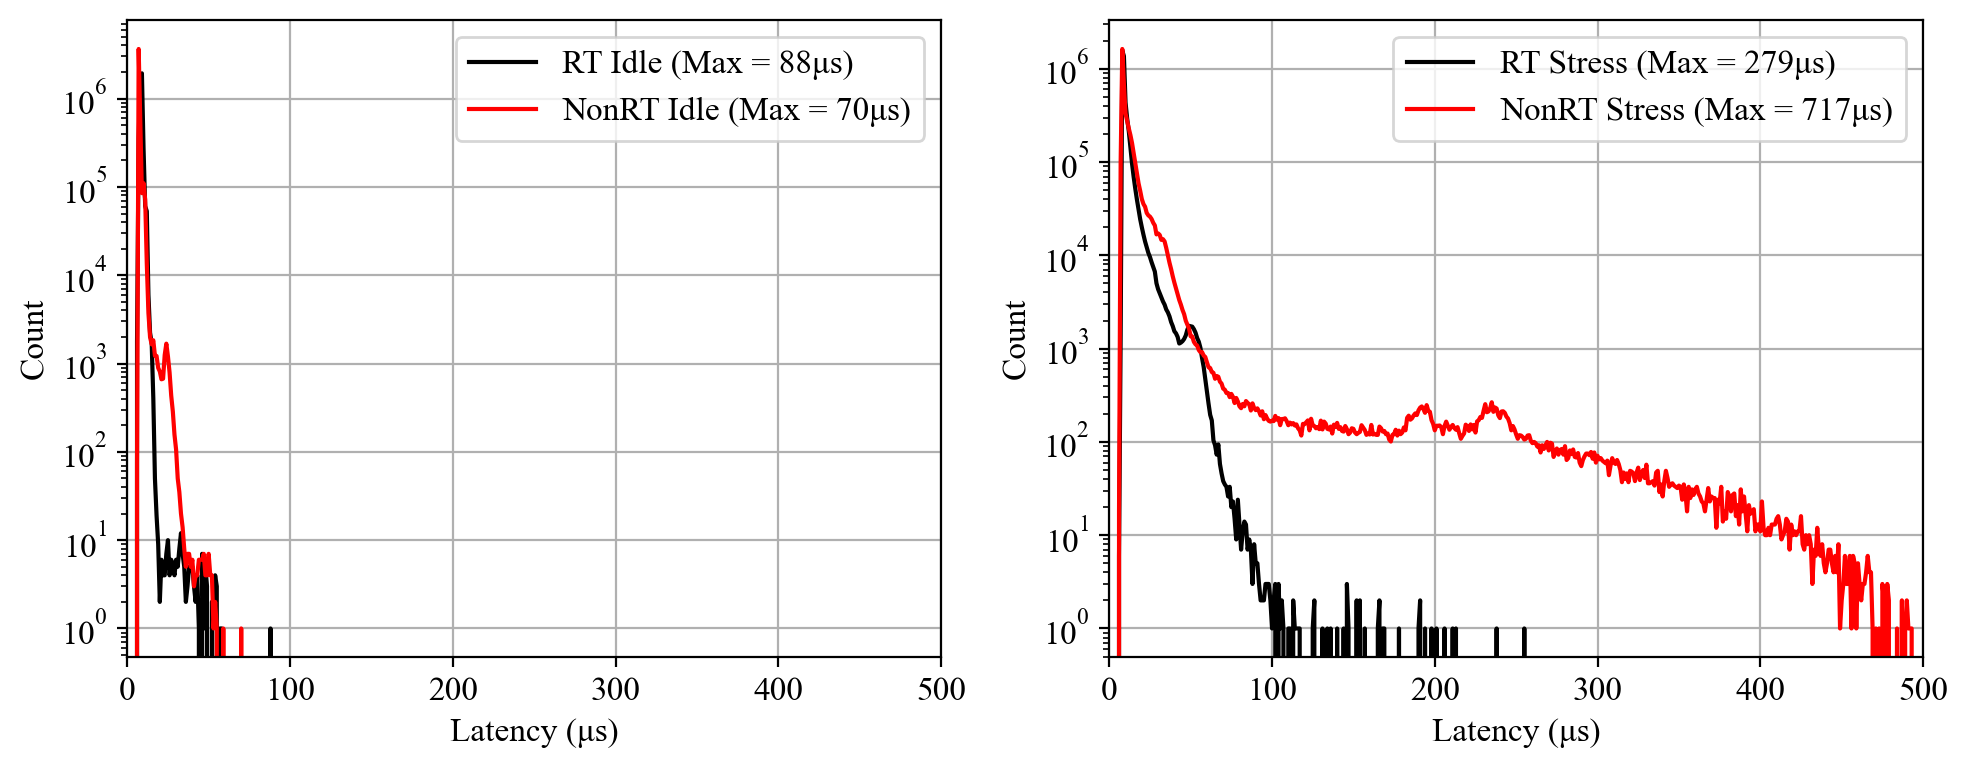

In [4]:
idle = load_histogram("data/idle-cyclictest.log", style="k-", label="RT Idle")
stress = load_histogram("data/stress-cyclictest.log", style="k-", label="RT Stress")

nonrt_idle = load_histogram("data/non-rt-cyclictest.log", style="r-", label="NonRT Idle")
nonrt_stress = load_histogram("data/non-rt-stress-cyclictest.log", style="r-", label="NonRT Stress")

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
plot_data((idle, nonrt_idle), ax=ax, xlim=(0, 500))

ax = fig.add_subplot(1, 2, 2)
plot_data((stress, nonrt_stress), ax=ax, xlim=(0, 500))

fig.tight_layout()
fig.savefig("rt-vs-non-rt-cyclic-test.svg")

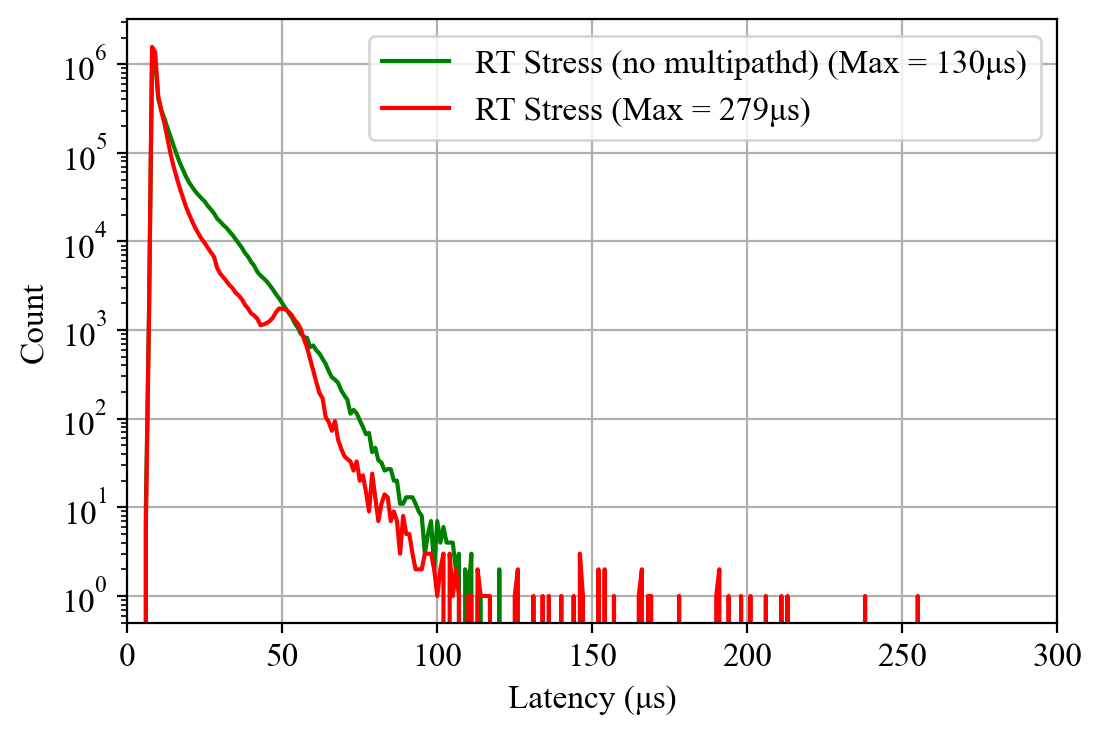

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# idle = load_histogram("data/idle-cyclictest.log", style="k-", label="RT Idle")
stress = load_histogram("data/stress-cyclictest.log", style="r-", label="RT Stress")
stress_no_mp = load_histogram("data/rt-stress-no-multipathd-cyclictest.log", style="g-", label="RT Stress (no multipathd)")

plot_data((stress_no_mp, stress), ax=ax, xlim=(0, 300))
fig.savefig("rt-vs-rt-no-multipathd.svg")

`multipathd` is a RT process which caused interferance. Removing it reduced max latency by a lot, but the distribution didn't change much. See https://github.com/ros-realtime/ros-realtime-rpi4-image/issues/30 for details.